# 🧠 OASIS – Optimización de Hiperparámetros para XGBoost

Este notebook realiza **búsqueda de hiperparámetros** para modelos XGBoost usando el dataset
`features_oasis_coronal.csv`.

## Objetivos

Se optimizan dos modelos:
- Clasificación **multiclase** (`CN`, `MCI`, `AD`).
- Clasificación **binaria temprana** (`CN` vs `MCI/AD`).

## Estrategias para Mejorar Recall

Este notebook implementa múltiples estrategias para **priorizar recall sobre precisión**, lo cual es crítico en detección temprana de Alzheimer (es mejor detectar más casos aunque haya algunas falsas alarmas):

1. **Optimización con `scoring='recall'`**: La búsqueda de hiperparámetros optimiza directamente para recall
2. **`scale_pos_weight`**: Ajusta el peso de la clase positiva para balancear el desbalance
3. **Ajuste de threshold**: Reduce el threshold de decisión para aumentar recall (disminuye falsos negativos)

## Visualizaciones

- **Curvas ROC** para modelos multiclase (One-vs-Rest) y binarios
- **Curvas Precision-Recall** para evaluar el trade-off
- **Análisis de threshold** para encontrar el punto óptimo donde recall > precision

Usaremos `RandomizedSearchCV` con validación cruzada estratificada.

## 1. Imports y carga de datos

En esta sección importamos las librerías necesarias y cargamos el dataset de características preprocesadas.

**Librerías utilizadas:**
- `numpy`, `pandas`: Manipulación de datos
- `matplotlib`, `seaborn`: Visualización
- `sklearn`: División de datos, validación cruzada, búsqueda de hiperparámetros y métricas
- `xgboost`: Modelo de clasificación XGBoost

El dataset se carga desde `data/processed/features_oasis_coronal.csv` que contiene las características extraídas de las imágenes de MRI.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve
)

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

# Configuración de rutas
BASE_DIR = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria"
CSV_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'features_oasis_coronal.csv')

# Cargar datos
df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
print(f'CSV cargado desde: {CSV_PATH}')
df.head()

Shape: (596, 534)
CSV cargado desde: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\processed\features_oasis_coronal.csv


,filepath,label,f_458,f_92,f_126,f_460,f_348,f_470,f_290,f_442,f_372,f_312,f_440,f_388,f_324,f_284,f_280,f_370,f_472,f_258,f_410,f_434,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_200,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,f_210,f_211,f_212,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_281,f_282,f_283,f_285,f_286,f_287,f_288,f_289,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,f_300,f_301,f_302,f_303,f_304,f_305,f_306,f_307,f_308,f_309,f_310,f_311,f_313,f_314,f_315,f_316,f_317,f_318,f_319,f_320,f_321,f_322,f_323,f_325,f_326,f_327,f_328,f_329,f_330,f_331,f_332,f_333,f_334,f_335,f_336,f_337,f_338,f_339,f_340,f_341,f_342,f_343,f_344,f_345,f_346,f_347,f_349,f_350,f_351,f_352,f_353,f_354,f_355,f_356,f_357,f_358,f_359,f_360,f_361,f_362,f_363,f_364,f_365,f_366,f_367,f_368,f_369,f_371,f_373,f_374,f_375,f_376,f_377,f_378,f_379,f_380,f_381,f_382,f_383,f_384,f_385,f_386,f_387,f_389,f_390,f_391,f_392,f_393,f_394,f_395,f_396,f_397,f_398,f_399,f_400,f_401,f_402,f_403,f_404,f_405,f_406,f_407,f_408,f_409,f_411,f_412,f_413,f_414,f_415,f_416,f_417,f_418,f_419,f_420,f_421,f_422,f_423,f_424,f_425,f_426,f_427,f_428,f_429,f_430,f_431,f_432,f_433,f_435,f_436,f_437,f_438,f_439,f_441,f_443,f_444,f_445,f_446,f_447,f_448,f_449,f_450,f_451,f_452,f_453,f_454,f_455,f_456,f_457,f_459,f_461,f_462,f_463,f_464,f_465,f_466,f_467,f_468,f_469,f_471,f_473,f_474,f_475,f_476,f_477,f_478,f_479,f_480,f_481,f_482,f_483,f_484,f_485,f_486,f_487,f_488,f_489,f_490,f_491,f_492,f_493,f_494,f_495,f_496,f_497,f_498,f_499,f_500,f_501,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511,f_512,f_513,f_514,f_515,f_516,f_517,f_518,f_519,f_520,f_521,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,-0.937640,1.070091,0.720543,-0.895420,1.653419,-0.897521,1.079860,-0.960886,0.554381,0.196237,-0.886278,-0.829725,0.410757,0.428201,0.341225,1.015169,-0.900353,-0.003951,-0.777544,-0.631744,-0.941088,0.078861,-0.938237,0.088586,-0.946446,0.083849,-0.603710,0.709252,0.238158,1.556840,0.170087,1.286804,0.047764,1.011708,0.175264,0.967896,0.028956,0.995072,0.171440,0.969095,0.026514,0.995348,0.113926,1.247540,-0.161667,1.264034,-0.916812,0.095404,-0.951572,0.069847,-0.949734,0.070261,-0.926689,0.068053,-0.880960,0.137726,0.379179,1.558055,0.568308,1.476871,-0.116831,0.455321,0.102612,0.563714,-0.143720,0.539638,-0.076718,0.480998,-0.222371,0.405157,0.276683,0.574072,-0.113095,0.526242,-0.274075,0.484000,-0.084099,1.002445,0.594937,1.425104,-0.680665,0.695817,-0.973725,0.063409,-0.910901,0.132481,0.611033,1.351498,0.135391,1.187134,-0.2539

### 1.1. Definir features y etiquetas

In [2]:
feature_cols = [c for c in df.columns if c.startswith('f_')]
X = df[feature_cols].values
y_labels = df['label'].values

le = LabelEncoder()
y_multi = le.fit_transform(y_labels)
print('Clases:', dict(zip(le.classes_, le.transform(le.classes_))))

Clases: {'AD': np.int64(0), 'CN': np.int64(1), 'MCI': np.int64(2)}


## 2. Split Train/Test y configuración de CV

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi,
    test_size=0.2,
    random_state=42,
    stratify=y_multi
)

print('Train:', X_train.shape, 'Test:', X_test.shape)

# OPTIMIZACIÓN: Reducir n_splits de 4 a 3 para reducir tiempo (3 folds = 33% menos tiempo)
# Si necesitas más robustez, puedes usar n_splits=4 o 5
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print(f'Usando {cv.n_splits} folds para validación cruzada')

Train: (476, 532) Test: (120, 532)
Usando 3 folds para validación cruzada


## 3. Espacio de búsqueda para XGBoost (multiclase)

### ⚡ Optimizaciones de Tiempo de Ejecución

Este notebook incluye optimizaciones para reducir el tiempo de ejecución:

1. **Reducción de folds CV**: De 4 a 3 folds (33% menos tiempo)
2. **Reducción de iteraciones**: De 20 a 10 iteraciones en modo rápido (50% menos tiempo)
3. **Espacio de búsqueda reducido**: Menos valores por parámetro en modo rápido
4. **Paralelización**: `n_jobs=-1` usa todos los cores disponibles

**Modos disponibles:**
- **`VERSION = 'fast'`**: Búsqueda rápida (10 iteraciones, espacio reducido) - **Recomendado para pruebas**
- **`VERSION = 'full'`**: Búsqueda exhaustiva (15 iteraciones, espacio completo) - Para resultados finales

**Tiempo estimado:**
- Modo rápido: ~5-10 minutos por modelo
- Modo completo: ~15-25 minutos por modelo

Para cambiar el modo, modifica la variable `VERSION` en la celda siguiente.

In [8]:
# OPTIMIZACIÓN: Reducir espacio de búsqueda y n_iter para acelerar
# Versión rápida (recomendada para pruebas):
param_dist_multi_fast = {
    'n_estimators': [200, 400],  # Reducido de [200, 400, 600] a 2 valores
    'max_depth': [3, 4, 5],      # Reducido de [3, 4, 5, 6] a 3 valores
    'learning_rate': [0.03, 0.05, 0.1],  # Reducido de 4 a 3 valores
    'subsample': [0.8, 0.9, 1.0],  # Reducido de 4 a 3 valores
    'colsample_bytree': [0.8, 0.9, 1.0],  # Reducido de 4 a 3 valores
}

# Versión completa (más lenta pero más exhaustiva):
param_dist_multi_full = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

# Seleccionar versión (cambiar a 'full' para búsqueda exhaustiva)
VERSION = 'fast'  # 'fast' o 'full'
param_dist_multi = param_dist_multi_fast if VERSION == 'fast' else param_dist_multi_full

xgb_base_multi = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    tree_method='hist',
    random_state=42,
)

# OPTIMIZACIÓN: Reducir n_iter de 20 a 10-15 para acelerar
# n_iter=10: ~50% menos tiempo, n_iter=15: ~25% menos tiempo
N_ITER = 10 if VERSION == 'fast' else 15

random_search_multi = RandomizedSearchCV(
    estimator=xgb_base_multi,
    param_distributions=param_dist_multi,
    n_iter=N_ITER,  # Reducido de 20
    scoring='neg_log_loss',
    n_jobs=-1,  # Usa todos los cores disponibles
    cv=cv,
    verbose=1,
    random_state=42,
)

print(f'Búsqueda con {N_ITER} iteraciones y {cv.n_splits} folds')
print(f'Total de modelos a entrenar: {N_ITER * cv.n_splits}')
print('Iniciando búsqueda...\n')

import time
start_time = time.time()
random_search_multi.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print(f'\n⏱️  Tiempo de ejecución: {elapsed_time/60:.2f} minutos ({elapsed_time:.1f} segundos)')
print('\nMejores hiperparámetros (multiclase):')
print(random_search_multi.best_params_)
print('Mejor score (neg_log_loss):', random_search_multi.best_score_)

Búsqueda con 10 iteraciones y 3 folds
Total de modelos a entrenar: 30
Iniciando búsqueda...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

⏱️  Tiempo de ejecución: 8.02 minutos (481.4 segundos)

Mejores hiperparámetros (multiclase):
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Mejor score (neg_log_loss): -0.38992871728630707


### 3.1. Evaluar mejor modelo multiclase

Reporte de clasificación (multiclase):
              precision    recall  f1-score   support

          AD       1.00      0.60      0.75        10
          CN       0.92      1.00      0.96        70
         MCI       0.97      0.93      0.95        40

    accuracy                           0.94       120
   macro avg       0.96      0.84      0.89       120
weighted avg       0.95      0.94      0.94       120

ROC-AUC macro (OVR): 0.9955527597402597


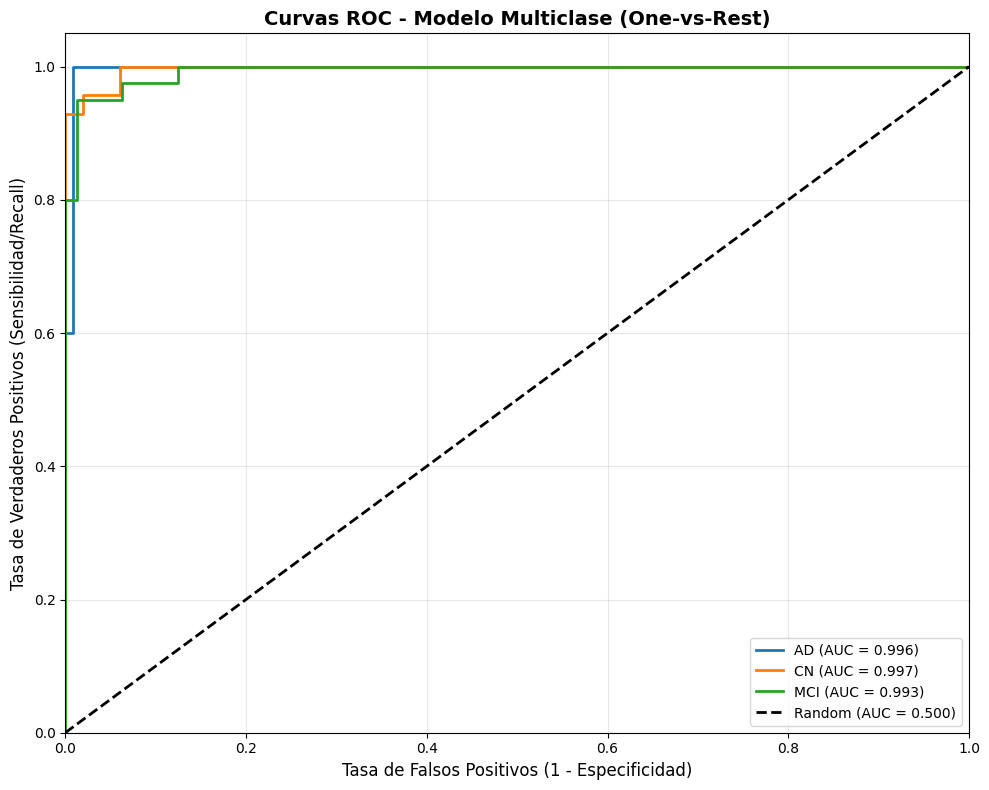

In [9]:
best_multi = random_search_multi.best_estimator_
y_proba_test = best_multi.predict_proba(X_test)
y_pred_test = best_multi.predict(X_test)

print('Reporte de clasificación (multiclase):')
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

try:
    roc_macro = roc_auc_score(y_test, y_proba_test, multi_class='ovr')
    print('ROC-AUC macro (OVR):', roc_macro)
except Exception as e:
    print('No se pudo calcular ROC-AUC multiclase:', e)

# Curvas ROC para modelo multiclase (One-vs-Rest)
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(le.classes_):
    y_binary_class = (y_test == i).astype(int)
    fpr, tpr, _ = roc_curve(y_binary_class, y_proba_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad/Recall)', fontsize=12)
plt.title('Curvas ROC - Modelo Multiclase (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Optimización para modelo binario (CN vs MCI/AD)

In [ ]:
# 0 = CN, 1 = MCI/AD
y_binary = (df['label'] != 'CN').astype(int).values

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print('Train binario:', X_train_b.shape, 'Test binario:', X_test_b.shape)

# OPTIMIZACIÓN: Usar el mismo espacio de búsqueda optimizado
param_dist_bin_fast = {
    'n_estimators': [200, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

param_dist_bin_full = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

param_dist_bin = param_dist_bin_fast if VERSION == 'fast' else param_dist_bin_full

xgb_base_bin = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=42,
)

# Modelo optimizado para recall (prioriza detectar casos positivos)
# Calculamos scale_pos_weight para balancear hacia recall
pos_count = np.sum(y_train_b == 1)
neg_count = np.sum(y_train_b == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

xgb_base_bin_recall = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # Prioriza recall
)

random_search_bin = RandomizedSearchCV(
    estimator=xgb_base_bin,
    param_distributions=param_dist_bin,
    n_iter=N_ITER,  # Usar el mismo N_ITER optimizado
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
)

random_search_bin_recall = RandomizedSearchCV(
    estimator=xgb_base_bin_recall,
    param_distributions=param_dist_bin,
    n_iter=N_ITER,  # Usar el mismo N_ITER optimizado
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
)

print(f'Entrenando modelo binario 1/2 ({N_ITER} iteraciones, {cv.n_splits} folds)...')
start_time = time.time()
random_search_bin.fit(X_train_b, y_train_b)

print(f'\nEntrenando modelo binario 2/2 ({N_ITER} iteraciones, {cv.n_splits} folds)...')
start_time = time.time()
random_search_bin_recall.fit(X_train_b, y_train_b)

print('\n=== Modelo 1: Optimizado para ROC-AUC ===')
print('Mejores hiperparámetros:', random_search_bin.best_params_)
print('Mejor Recall (CV):', random_search_bin.best_score_)

print('\n=== Modelo 2: Optimizado para Recall con scale_pos_weight ===')
print('Mejores hiperparámetros:', random_search_bin_recall.best_params_)
print('Mejor Recall (CV):', random_search_bin_recall.best_score_)
print(f'scale_pos_weight usado: {scale_pos_weight:.3f}')

Train binario: (476, 532) Test binario: (120, 532)
Entrenando modelo binario 1/2 (10 iteraciones, 3 folds)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
⏱️  Tiempo modelo 1: 1.06 minutos

Entrenando modelo binario 2/2 (10 iteraciones, 3 folds)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
⏱️  Tiempo modelo 2: 0.88 minutos

⏱️  Tiempo total modelos binarios: 1.94 minutos

=== Modelo 1: Optimizado para ROC-AUC ===
Mejores hiperparámetros: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Mejor Recall (CV): 0.8466977466977467

=== Modelo 2: Optimizado para Recall con scale_pos_weight ===
Mejores hiperparámetros: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Mejor Recall (CV): 0.8519813519813519
scale_pos_weight usado: 1.429


### 4.1. Evaluar mejor modelo binario en Test

### 4.2. Ajuste de Threshold para Optimizar Recall

Para mejorar aún más el recall (disminuyendo falsos negativos), podemos ajustar el threshold de decisión. 
Un threshold más bajo aumenta el recall pero puede disminuir la precisión.


Threshold óptimo seleccionado: 0.250

Métricas con threshold óptimo:
              precision    recall  f1-score   support

          CN       0.95      0.84      0.89        70
      MCI/AD       0.81      0.94      0.87        50

    accuracy                           0.88       120
   macro avg       0.88      0.89      0.88       120
weighted avg       0.89      0.88      0.88       120



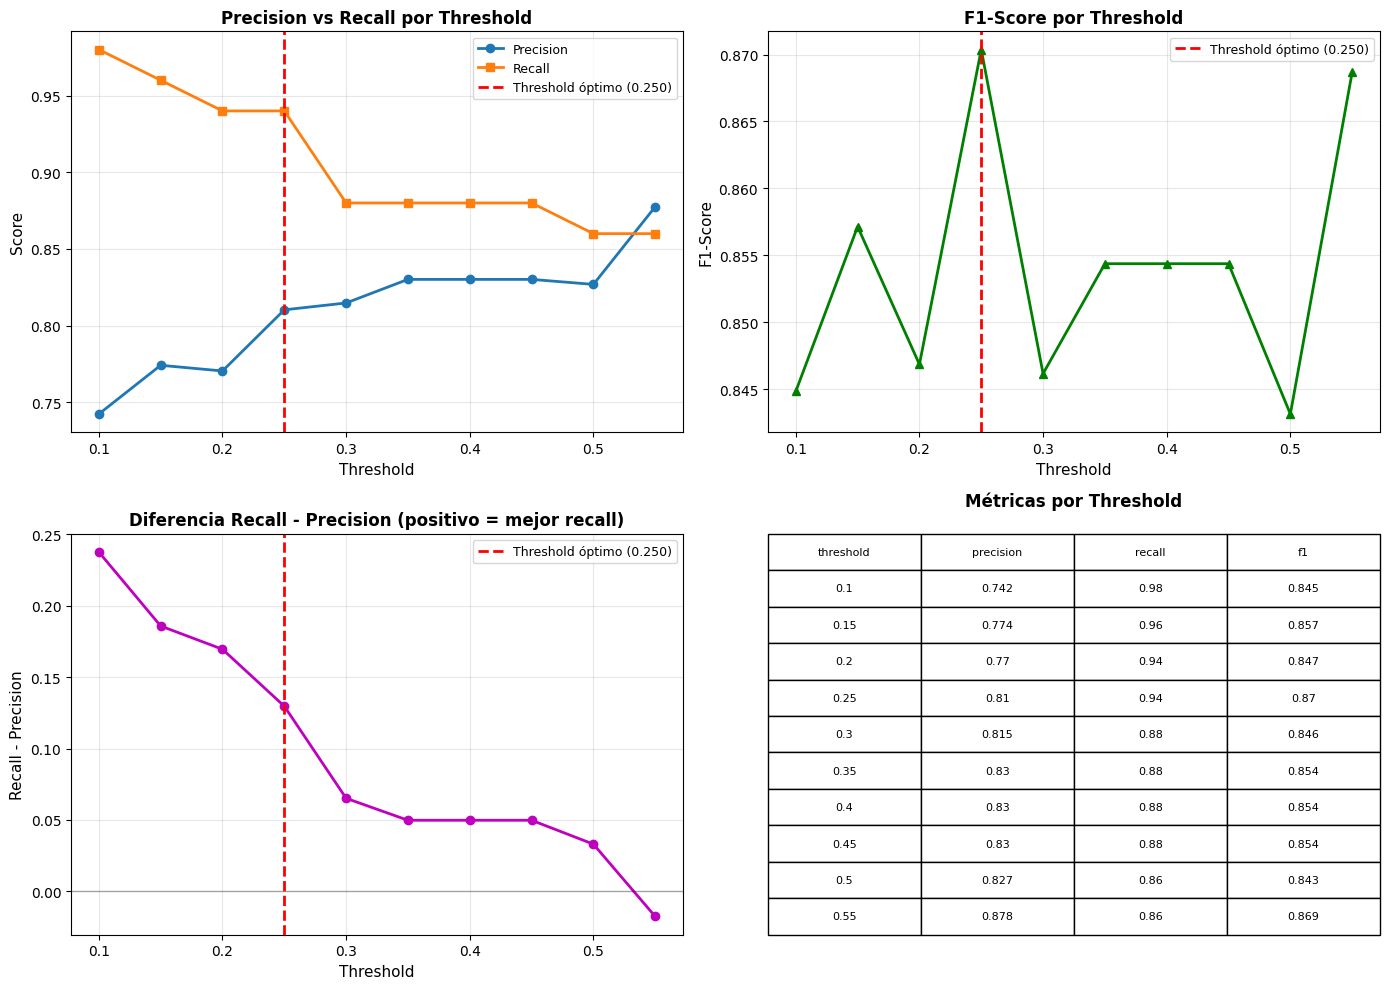


COMPARACIÓN: Threshold Default (0.5) vs Óptimo
           Threshold 0.5 (Default)  Threshold 0.250 (Óptimo)
Precision                   0.8269                    0.8103
Recall                      0.8600                    0.9400
F1-Score                    0.8431                    0.8704

✓ Mejora en Recall: 0.0800


In [13]:
# Usar el modelo optimizado para recall
# NOTA: best_bin_recall se define en la celda siguiente, así que usamos directamente el best_estimator_
best_model_recall = random_search_bin_recall.best_estimator_

# Obtener probabilidades
y_proba_recall = best_model_recall.predict_proba(X_test_b)[:, 1]

# Función auxiliar para obtener la clave de la clase positiva en classification_report
def get_positive_class_key(report_dict):
    """Obtiene la clave de la clase positiva (MCI/AD) en el reporte de clasificación."""
    if 'MCI/AD' in report_dict:
        return 'MCI/AD'
    elif '1' in report_dict:
        return '1'
    else:
        # Si no encontramos, usar la última clave que no sea métricas agregadas
        excluded = ['accuracy', 'macro avg', 'weighted avg']
        class_keys = [k for k in report_dict.keys() if k not in excluded]
        return class_keys[-1] if class_keys else '1'

# Probar diferentes thresholds
thresholds = np.arange(0.1, 0.6, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_recall >= threshold).astype(int)
    report = classification_report(y_test_b, y_pred_thresh, output_dict=True, target_names=['CN', 'MCI/AD'])
    
    # Obtener la clave correcta para la clase positiva
    class_key = get_positive_class_key(report)
    
    results.append({
        'threshold': threshold,
        'precision': report[class_key]['precision'],
        'recall': report[class_key]['recall'],
        'f1': report[class_key]['f1-score'],
        'accuracy': report['accuracy']
    })

results_df = pd.DataFrame(results)

# Encontrar threshold óptimo (recall > precision)
optimal_thresholds = results_df[results_df['recall'] > results_df['precision']]
if len(optimal_thresholds) > 0:
    # Seleccionar el threshold con mejor balance recall/precision
    optimal_threshold = optimal_thresholds.loc[optimal_thresholds['f1'].idxmax(), 'threshold']
else:
    # Si no hay threshold donde recall > precision, usar el que maximiza recall
    optimal_threshold = results_df.loc[results_df['recall'].idxmax(), 'threshold']

print(f'Threshold óptimo seleccionado: {optimal_threshold:.3f}')
print('\nMétricas con threshold óptimo:')
y_pred_optimal = (y_proba_recall >= optimal_threshold).astype(int)
print(classification_report(y_test_b, y_pred_optimal, target_names=['CN', 'MCI/AD']))

# Visualizar trade-off threshold
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Precision vs Recall por threshold
axes[0, 0].plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision', linewidth=2, markersize=6)
axes[0, 0].plot(results_df['threshold'], results_df['recall'], 's-', label='Recall', linewidth=2, markersize=6)
axes[0, 0].axvline(optimal_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold óptimo ({optimal_threshold:.3f})')
axes[0, 0].set_xlabel('Threshold', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Precision vs Recall por Threshold', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Gráfico 2: F1-Score por threshold
axes[0, 1].plot(results_df['threshold'], results_df['f1'], 'g^-', linewidth=2, markersize=6)
axes[0, 1].axvline(optimal_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold óptimo ({optimal_threshold:.3f})')
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('F1-Score por Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# Gráfico 3: Diferencia Recall - Precision
results_df['recall_precision_diff'] = results_df['recall'] - results_df['precision']
axes[1, 0].plot(results_df['threshold'], results_df['recall_precision_diff'], 'mo-', linewidth=2, markersize=6)
axes[1, 0].axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.3)
axes[1, 0].axvline(optimal_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold óptimo ({optimal_threshold:.3f})')
axes[1, 0].set_xlabel('Threshold', fontsize=11)
axes[1, 0].set_ylabel('Recall - Precision', fontsize=11)
axes[1, 0].set_title('Diferencia Recall - Precision (positivo = mejor recall)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(alpha=0.3)

# Gráfico 4: Tabla comparativa de métricas
axes[1, 1].axis('off')
table_data = results_df[['threshold', 'precision', 'recall', 'f1']].round(3)
table = axes[1, 1].table(cellText=table_data.values,
                         colLabels=table_data.columns,
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
axes[1, 1].set_title('Métricas por Threshold', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Comparación final: threshold default vs óptimo
print('\n' + '='*60)
print('COMPARACIÓN: Threshold Default (0.5) vs Óptimo')
print('='*60)

y_pred_default = (y_proba_recall >= 0.5).astype(int)
y_pred_opt = (y_proba_recall >= optimal_threshold).astype(int)

# Obtener reportes y claves
report_default = classification_report(y_test_b, y_pred_default, output_dict=True, target_names=['CN', 'MCI/AD'])
report_opt = classification_report(y_test_b, y_pred_opt, output_dict=True, target_names=['CN', 'MCI/AD'])
class_key_default = get_positive_class_key(report_default)
class_key_opt = get_positive_class_key(report_opt)

comparison_final = pd.DataFrame({
    'Threshold 0.5 (Default)': [
        report_default[class_key_default]['precision'],
        report_default[class_key_default]['recall'],
        report_default[class_key_default]['f1-score']
    ],
    f'Threshold {optimal_threshold:.3f} (Óptimo)': [
        report_opt[class_key_opt]['precision'],
        report_opt[class_key_opt]['recall'],
        report_opt[class_key_opt]['f1-score']
    ]
}, index=['Precision', 'Recall', 'F1-Score'])

print(comparison_final.round(4))
print(f'\n✓ Mejora en Recall: {comparison_final.loc["Recall", f"Threshold {optimal_threshold:.3f} (Óptimo)"] - comparison_final.loc["Recall", "Threshold 0.5 (Default)"]:.4f}')


MODELO 1: Optimizado para ROC-AUC
              precision    recall  f1-score   support

          CN       0.91      0.91      0.91        70
      MCI/AD       0.88      0.88      0.88        50

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120

ROC-AUC Test: 0.9646

MODELO 2: Optimizado para Recall (con scale_pos_weight)
              precision    recall  f1-score   support

          CN       0.90      0.87      0.88        70
      MCI/AD       0.83      0.86      0.84        50

    accuracy                           0.87       120
   macro avg       0.86      0.87      0.86       120
weighted avg       0.87      0.87      0.87       120

ROC-AUC Test: 0.9643


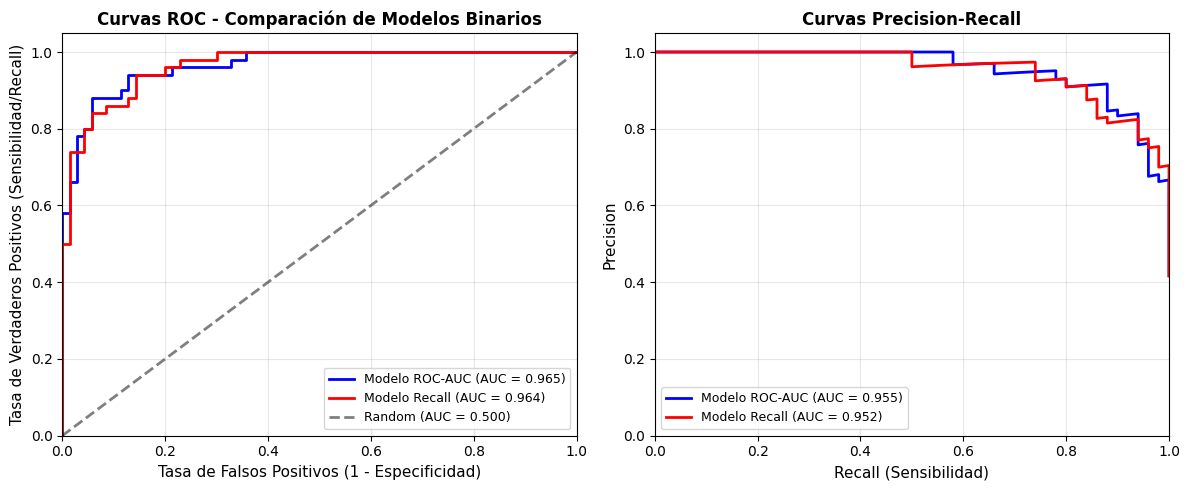


COMPARACIÓN DE MÉTRICAS
           Modelo ROC-AUC  Modelo Recall
ROC-AUC            0.9646         0.9643
Precision          0.8800         0.8269
Recall             0.8800         0.8600
F1-Score           0.8800         0.8431


In [14]:
# Evaluar ambos modelos
best_bin = random_search_bin.best_estimator_
best_bin_recall = random_search_bin_recall.best_estimator_

# Predicciones del modelo optimizado para ROC-AUC
y_proba_test_b = best_bin.predict_proba(X_test_b)[:,1]
y_pred_test_b = best_bin.predict(X_test_b)

# Predicciones del modelo optimizado para Recall
y_proba_test_b_recall = best_bin_recall.predict_proba(X_test_b)[:,1]
y_pred_test_b_recall = best_bin_recall.predict(X_test_b)

print('='*60)
print('MODELO 1: Optimizado para ROC-AUC')
print('='*60)
print(classification_report(y_test_b, y_pred_test_b, target_names=['CN', 'MCI/AD']))
roc_test_b = roc_auc_score(y_test_b, y_proba_test_b)
print(f'ROC-AUC Test: {roc_test_b:.4f}')

print('\n' + '='*60)
print('MODELO 2: Optimizado para Recall (con scale_pos_weight)')
print('='*60)
print(classification_report(y_test_b, y_pred_test_b_recall, target_names=['CN', 'MCI/AD']))
roc_test_b_recall = roc_auc_score(y_test_b, y_proba_test_b_recall)
print(f'ROC-AUC Test: {roc_test_b_recall:.4f}')

# Curvas ROC comparativas
plt.figure(figsize=(12, 5))

# Subplot 1: Curvas ROC
plt.subplot(1, 2, 1)
fpr1, tpr1, _ = roc_curve(y_test_b, y_proba_test_b)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, lw=2, label=f'Modelo ROC-AUC (AUC = {roc_auc1:.3f})', color='blue')

fpr2, tpr2, _ = roc_curve(y_test_b, y_proba_test_b_recall)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, lw=2, label=f'Modelo Recall (AUC = {roc_auc2:.3f})', color='red')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=11)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad/Recall)', fontsize=11)
plt.title('Curvas ROC - Comparación de Modelos Binarios', fontsize=12, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)

# Subplot 2: Curvas Precision-Recall
plt.subplot(1, 2, 2)
precision1, recall1, _ = precision_recall_curve(y_test_b, y_proba_test_b)
pr_auc1 = auc(recall1, precision1)
plt.plot(recall1, precision1, lw=2, label=f'Modelo ROC-AUC (AUC = {pr_auc1:.3f})', color='blue')

precision2, recall2, _ = precision_recall_curve(y_test_b, y_proba_test_b_recall)
pr_auc2 = auc(recall2, precision2)
plt.plot(recall2, precision2, lw=2, label=f'Modelo Recall (AUC = {pr_auc2:.3f})', color='red')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensibilidad)', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Curvas Precision-Recall', fontsize=12, fontweight='bold')
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Comparación de métricas
print('\n' + '='*60)
print('COMPARACIÓN DE MÉTRICAS')
print('='*60)

# Obtener reportes y claves
report_roc = classification_report(y_test_b, y_pred_test_b, output_dict=True, target_names=['CN', 'MCI/AD'])
report_recall = classification_report(y_test_b, y_pred_test_b_recall, output_dict=True, target_names=['CN', 'MCI/AD'])
class_key_roc = get_positive_class_key(report_roc)
class_key_recall = get_positive_class_key(report_recall)

comparison = pd.DataFrame({
    'Modelo ROC-AUC': [
        roc_auc_score(y_test_b, y_proba_test_b),
        report_roc[class_key_roc]['precision'],
        report_roc[class_key_roc]['recall'],
        report_roc[class_key_roc]['f1-score']
    ],
    'Modelo Recall': [
        roc_auc_score(y_test_b, y_proba_test_b_recall),
        report_recall[class_key_recall]['precision'],
        report_recall[class_key_recall]['recall'],
        report_recall[class_key_recall]['f1-score']
    ]
}, index=['ROC-AUC', 'Precision', 'Recall', 'F1-Score'])
print(comparison.round(4))